In [59]:
from SimPEG import *
# import sys
# sys.path.append("./simpegdc/")
import simpegDCIP as DC

import matplotlib.pyplot as plt

%matplotlib inline

In [60]:
npad = 10
cs = 2.
hx = [(cs,npad, -1.3),(cs,100+1),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,50)]
mesh = Mesh.TensorMesh([hx, hy], "CN")

circmap = Maps.CircleMap(mesh)
circmap.slope = 1e5
xr = np.linspace(-40, 40, 20)
dxr = np.diff(xr)

txList = []
zloc = -2.5

In [61]:
mesh.vnC

array([121,  60])

In [62]:
A, B = -20., 20.
src = DC.SrcDipole([],np.r_[A,cs/2.],np.r_[B,cs/2.])

survey = DC.SurveyDC([src])
problem = DC.ProblemDC_CC(mesh, mapping = circmap)

# DC.ProblemDC
problem.pair(survey)

In [63]:
sigblk, sighalf = 2e-3, 2e-3
xc, yc, r = -15, -8, 4
model = np.r_[np.log(sigblk), np.log(sighalf), xc, yc, r]

In [64]:
fields = problem.fields(model)

In [65]:
phi = fields[:]['phi_sol']

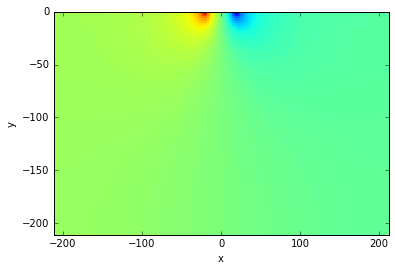

In [66]:
mesh.plotImage(phi)
plt.show()

In [67]:
x = np.arange(-40,41,dtype=float)
P = mesh.getInterpolationMat(Utils.ndgrid(x,np.r_[-1.]),'CC')
phiplt = P*phi

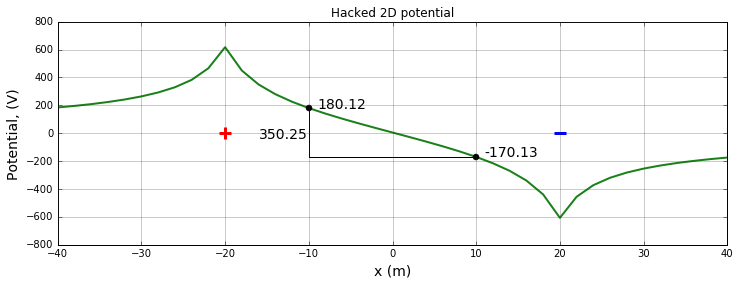

In [68]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(x,phiplt,color=[0.1,0.5,0.1],linewidth=2)
ax.grid(which='both',linestyle='-',linewidth=0.5,color=[0.2,0.2,0.2],alpha=0.5)
ax.plot(A,0.,'+',markersize = 12, markeredgewidth = 3, color=[1.,0.,0])
ax.plot(B,0.,'_',markersize = 12, markeredgewidth = 3, color=[0.,0.,1.])
ax.set_ylabel('Potential, (V)',fontsize = 14)
ax.set_xlabel('x (m)',fontsize = 14)
ax.set_xlim([x.min(),x.max()])
ax.set_title('Hacked 2D potential')

M,N = -10.,10.
VM, VN = phiplt[int(M-x[0])], phiplt[int(N-x[0])]

ax.plot(M,phiplt[int(M-x[0])],'o',color='k')
ax.plot(N,phiplt[int(N-x[0])],'o',color='k')

props = dict(boxstyle='round', facecolor='grey', alpha=0.3)

if A < B:
    
    if M <= A:
        xytextM = (M-6.,VM+1)
    elif M > A:
        xytextM = (M+1.,VM+1)
    
    if N <= B:
        xytextN = (N+1.,VN+1)
    elif N > B:
        xytextN = (N+1.,VN-80)
        
elif A > B:
    print 'here'

ax.annotate('%2.2f'%(VM), xy=(M,VM), xytext=xytextM,fontsize = 14)
ax.annotate('%2.2f'%(VN), xy=(N,VN), xytext=xytextN,fontsize = 14)

ax.plot(np.r_[M,N],np.ones(2)*VN,color='k')
ax.plot(np.r_[M,M],np.r_[VM, VN],color='k')
ax.annotate('%2.2f'%(VM-VN) , xy=(M,(VM+VN)/2.-1), xytext=(M-6,(VM+VN)/2.-40.),fontsize = 14)

In [73]:
rho1 = 1e-2
rho2 = 1e-2

infty = 10

def get_Layer_Potentials(rho1,rho2,h,A,B,x,y,z,infty=10):
    xyz = Utils.ndgrid(x,y,z)
    k = (rho2-rho1) / (rho2+rho1)
    
    eps = 1e-6 #to stabilize division
    r = lambda src_loc: np.sqrt((xyz[:,0] - src_loc[0])**2 + (xyz[:,1] - src_loc[1])**2 + (xyz[:,2] - src_loc[2])**2)+eps

    m = Utils.mkvc(np.arange(1,infty+1))
    sum_term = lambda r: np.sum(((k**m.T)*np.ones_like(Utils.mkvc(r,2))) / np.sqrt(1. + (2.*h*m.T/Utils.mkvc(r,2))**2),1)
    
    V = lambda I,src_loc: (I*rho1 / (2.*np.pi*r(src_loc))) * (1 + 2*sum_term(r(src_loc)))
    
    VA = V(1.,A)
    VB = V(-1.,B)
    
    return VA+VB

In [107]:
V = get_Layer_Potentials(rho1,rho2,1.,np.r_[A,0.,0.],np.r_[B,0.,0.],x,np.r_[0.],np.r_[0.])

G = 1. / ( 1./np.abs(A-M) - 1./np.abs(M-B) - 1./np.abs(N-A) + 1./np.abs(N-B) )
rho_a = (VM-VN)*2*np.pi*G

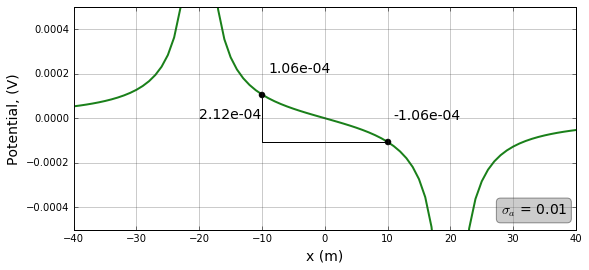

In [162]:
ylim = np.r_[-5e-4, 5e-4]
fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.plot(x,V,color=[0.1,0.5,0.1],linewidth=2)
ax.grid(which='both',linestyle='-',linewidth=0.5,color=[0.2,0.2,0.2],alpha=0.5)
# ax.annotate('+', xy=(A,ylim[0]), xytext=(A,ylim[0]),fontsize = 14,s
# ax.plot(A,ylim[0],'+',markersize = 12, markeredgewidth = 3, color=[1.,0.,0])
# ax.plot(B,ylim[0],'_',markersize = 12, markeredgewidth = 3, color=[0.,0.,1.])
ax.set_ylabel('Potential, (V)',fontsize = 14)
ax.set_xlabel('x (m)',fontsize = 14)
ax.set_xlim([x.min(),x.max()])
ax.set_ylim(ylim)

M,N = -10.,10.
VM, VN = V[int(M-x[0])], V[int(N-x[0])]

ax.plot(M,V[int(M-x[0])],'o',color='k')
ax.plot(N,V[int(N-x[0])],'o',color='k')

props = dict(boxstyle='round', facecolor='grey', alpha=0.3)

txtsp = 1e-4

if A < B:
    if M <= A:
        xytextM = (M-1.,VM+txtsp)
    elif M > A:
        xytextM = (M+1.,VM+txtsp)
    
    if N <= B:
        xytextN = (N+1.,VN+txtsp)
    elif N > B:
        xytextN = (N+1.,VN-txtsp)
        
elif A > B:
    print 'here'

ax.annotate('%2.2e'%(VM), xy=(M,VM), xytext=xytextM,fontsize = 14)
ax.annotate('%2.2e'%(VN), xy=(N,VN), xytext=xytextN,fontsize = 14)

ax.plot(np.r_[M,N],np.ones(2)*VN,color='k')
ax.plot(np.r_[M,M],np.r_[VM, VN],color='k')
ax.annotate('%2.2e'%(VM-VN) , xy=(M,(VM+VN)/2), xytext=(M-10,(VM+VN)/2.),fontsize = 14)

props = dict(boxstyle='round', facecolor='grey', alpha=0.4)
ax.text(x.max()-12,ylim.min()+ylim[1]*0.1,'$\sigma_a$ = %2.2f'%(rho_a),
            verticalalignment='bottom', bbox=props, fontsize = 14)

In [100]:
M,N = -2.,2.
VM, VN = V[int(M-x[0])], V[int(N-x[0])]

In [98]:
print VM, VN

1.60762552541e-05 -1.60762552541e-05


0.0099999989898990685

In [58]:
G

49.500000000000021